# Movie Rating Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [11,7]

The goal of this project is to analyze a dataset of movie ratings from MovieLens to determine whether users who rate more movies give higher or lower ratings compared to users who rate fewer movies.

## Data Import and Formatting

In [2]:
movies = pd.read_csv('./ml-latest/movies.csv', sep=',')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings = pd.read_csv('./ml-latest/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [4]:
del ratings['timestamp']
del movies['genres']

Checking if there are any null values in dataset:

In [5]:
print(movies.isnull().any())
print(ratings.isnull().any())

movieId    False
title      False
dtype: bool
userId     False
movieId    False
rating     False
dtype: bool


No null values!

Now we will calculate the average rating for each movie using the ratings dataset.

In [6]:
avg_ratings = ratings[['movieId','rating']].groupby('movieId').mean()
avg_ratings.head()
#print(avg_ratings.shape)

,rating
movieId,
1,3.888157
2,3.236953
3,3.175550
4,2.875713
5,3.079565


Adding a column with standard deviations:

In [7]:
avg_ratings_std = ratings[['movieId','rating']].groupby('movieId').std()
avg_ratings_std.columns = ['st dev']

In [8]:
avg_ratings = pd.concat([avg_ratings, avg_ratings_std], axis = 1, join = 'inner')
avg_ratings.head()

,rating,st dev
movieId,,
1,3.888157,0.927513
2,3.236953,0.958437
3,3.175550,1.013307
4,2.875713,1.111442
5,3.079565,0.993108


We now have a dataframe of each movie's average rating and rating standard deviation.

Next, we will look at ratings by individual users:

In [9]:
ratings_per_user = ratings[['userId','rating']].groupby('userId').count()
ratings_per_user.columns = ['# of ratings']
ratings_per_user.head()

,# of ratings
userId,
1,27
2,22
3,10
4,62
5,26


Text(0.5,1,'Number of ratings per user')

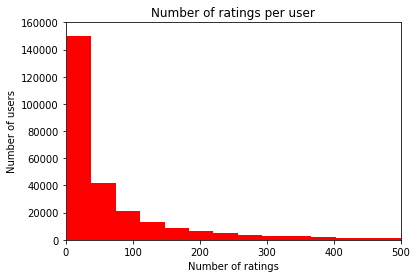

In [10]:
#Let's take a look at a histogram of the number of ratings per user:
plt.hist(ratings_per_user['# of ratings'], bins = 500, color = 'r')
plt.axis([0,500,0,160000])
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.title('Number of ratings per user')

From this, we see that the vast majority of users have rated very few movies. There is a long tail to the right.

In [11]:
ratings_per_user['# of ratings'].max()

18276

There was one user who rated over 18,000 movies!

### Z-Scores

Next, we'll try to calculate the z scores for every single rating in the ratings dataframe. Because there are 26 million reviews, we have to find a method that is efficient enough to run in a reasonable amount of time.

#### Method 1:
Iterate over every single rating and reference the mean and st dev in avg_ratings to calculate z-scores.

In [12]:
#small_ratings_1 = ratings[:10]
#small_ratings_1['z score'] = np.nan
#print(small_ratings_1)

In [13]:
#for row in small_ratings_1.itertuples():
#    small_ratings_1['z score'].iloc[row[0]] = (row[3] - avg_ratings['rating'].loc[row[2]]) / avg_ratings['st dev'].loc[row[2]]

In [14]:
#ratings['z score'] = np.nan
#for row in ratings[:100].itertuples():
#    ratings['z score'].iloc[row[0]] = (row[3] - avg_ratings['rating'].loc[row[2]]) / avg_ratings['st dev'].loc[row[2]]
#ratings.head(10)

In [15]:
#ratings.shape

Next: use %timeit to find how long calculations will take.

Method 1 implementation: It takes 55 ms per loop -> 17 days to calculate all 26 million!

We need to find a faster method.

#### Method 2: 
Add mean and st dev columns to ratings dataframe, then use array operations to calculate the z scores.

In [16]:
# small_ratings_2 = ratings[:100]
# small_ratings_2['mean'], small_ratings_2['st dev'] = np.nan, np.nan
# small_ratings_2.head()

In [17]:
#for row in small_ratings_2.itertuples():
#    %timeit small_ratings_2['mean'].iloc[row[0]] = avg_ratings['rating'].loc[row[2]]
#    small_ratings_2['st dev'].iloc[row[0]] = avg_ratings['st dev'].loc[row[2]]
#small_ratings_2.head(10)

Method 2 took even longer - 66 ms per loop just to add new columns to the ratings table without even calculating z scores.

#### Method 3: 
First group the ratings database by MovieId, then build another dataframe with all of the means and st devs to match up with the ratings dataframe. Then use array operations to calculate z scores.
We'll iterate over the 45,000 movies instead of the 26 million ratings, which should save a lot of time.

In [18]:
movieId_ratings = ratings.sort_values(['movieId','userId'])
movieId_ratings.head()

,userId,movieId,rating
204,8,1,4.0
317,9,1,4.5
641,12,1,4.0
1358,20,1,4.0
1710,24,1,4.0


In [19]:
movieId_ratings_count = ratings[['movieId', 'userId']].groupby('movieId').count()
movieId_ratings_count.columns = ['# of reviews']
movieId_ratings_count.head(10)

,# of reviews
movieId,
1,66008
2,26060
3,15497
4,2981
5,15258
6,27895
7,15157
8,1521
9,4423


This tells us how many ratings each movie has. We'll use this to know how many ratings to apply a movie's mean and st dev to when we're iterating over the 45,000 movies.

In [20]:
avg_ratings = pd.concat([avg_ratings, movieId_ratings_count], axis = 1, join = 'inner')
avg_ratings.head(10)

,rating,st dev,# of reviews
movieId,,,
1,3.888157,0.927513,66008
2,3.236953,0.958437,26060
3,3.175550,1.013307,15497
4,2.875713,1.111442,2981
5,3.079565,0.993108,15258
6,3.841764,0.883211,27895
7,3.372105,0.962936,15157
8,3.129191,0.992360,1521
9,3.008365,0.966091,4423


In [21]:
avg_ratings.shape

(45115, 3)

Next, we will create two additional columns in movieId_ratings for mean and st dev. 
To fill in these values, we will iterate through avg_ratings and reference avg_ratings to add the mean and st dev values into the ratings dataframe.

In [22]:
movieId_ratings['mean'], movieId_ratings['st dev'] = np.nan, np.nan

In [23]:
# #Shortened version - first 50 movies - for testing purposes.
#start = 0 #tells which index to start at for each movie
# for row in avg_ratings[:50].itertuples():
#     movieId_ratings['mean'].iloc[start:start+row[3]] = row[1]
#     movieId_ratings['st dev'].iloc[start:start+row[3]] = row[2]
#     start += row[3]
# movieId_ratings.head(30)

Good news! The first 50 movies, which include the first take 43.5 seconds to run. Extrapolating this result to all 45,000 movies, we get a total runtime of ~3 hours, which is a whole lot better than 17 days.

In [25]:
# #Testing that the values switch at the right time between movies 2 and 3:
# print(movieId_ratings.iloc[92060:92072])

Eventually, we run this for the full length of time to get the dataframe with mean and st dev included for all 46,000 movies.
The dataframe has been split into 3 smaller dataframes to allow for easier calculation (so computer doesn't have to run for many hours consecutively).


We will export these dataframes as csvs so that the data can easily be accessed in the future without having to run that piece of code all over again.

In [26]:
# #Testing out calculation of z score with array operations in the df:
# movieId_ratings['z score'] = (movieId_ratings['rating'] - movieId_ratings['mean'])/movieId_ratings['st dev']
# movieId_ratings.head(10)
# #Only takes ~5 seconds. Will probably take longer when the values are no longer NaN.

In [27]:
# avg_ratings_0 = avg_ratings[:2000]
# n_ratings_through_0 = avg_ratings_0['# of reviews'].sum()
# print(n_ratings_through_0)
# #The movieId df will have this many rows for the first 23,000 movies.

In [28]:
# movieId_ratings_0 = movieId_ratings[:11367414]

In [29]:
# start = 0 #tells which index to start at for each movie
# for row in avg_ratings_0.itertuples():
#     movieId_ratings_0['mean'].iloc[start:start+row[3]] = row[1]
#     movieId_ratings_0['st dev'].iloc[start:start+row[3]] = row[2]
#     start += row[3]
# movieId_ratings.tail(20)

In [30]:
# movieId_ratings_0.to_csv('movieId_ratings_0.csv')

This worked! It only took ~40 minutes. movieId_ratings_0 goes from movies 0 to 2,000 (~11 million reviews).
The dataframe has been exported as movieId_ratings_0.csv.

In [31]:
# avg_ratings_1 = avg_ratings[2000:10000]
# n_ratings_through_1 = n_ratings_through_0 + avg_ratings_1['# of reviews'].sum()

In [32]:
# movieId_ratings_1 = movieId_ratings[n_ratings_through_0:n_ratings_through_1]

In [33]:
# start = 0 #tells which index to start at for each movie
# for row in avg_ratings_1.itertuples():
#     movieId_ratings_1['mean'].iloc[start:start+row[3]] = row[1]
#     movieId_ratings_1['st dev'].iloc[start:start+row[3]] = row[2]
#     start += row[3]
# movieId_ratings.head(20)

In [34]:
# movieId_ratings_1.to_csv('movieId_ratings_1.csv')

movieId_ratings_1 goes from movies 2,000 to 10,000 (~10 million reviews). Dataframe has been exported as movieId_ratings_1.csv.

In [35]:
# avg_ratings_2 = avg_ratings[10000:]
# n_ratings_through_2 = n_ratings_through_1 + avg_ratings_2['# of reviews'].sum()
# movieId_ratings_2 = movieId_ratings[n_ratings_through_1:n_ratings_through_2]

In [36]:
# movieId_ratings_2.shape

In [37]:
# start = 0 #tells which index to start at for each movie
# for row in avg_ratings_2.itertuples():
#     movieId_ratings_2['mean'].iloc[start:start+row[3]] = row[1]
#     movieId_ratings_2['st dev'].iloc[start:start+row[3]] = row[2]
#     start += row[3]
# movieId_ratings_2.head(20)

In [38]:
# movieId_ratings_2.to_csv('movieId_ratings_2.csv')

movieId_ratings_2 goes from movies 10,000 to the end (~5 million reviews). Dataframe has been exported as movieId_ratings_2.csv.

Overall, the calculations finished within about 2.5 hours.

Next, we will import the previously created csv files so that we don't have to wait for the above code to run whenever we restart the kernel.

In [39]:
movieId_ratings_0 = pd.read_csv('./movieId_ratings_0.csv', sep=',')
movieId_ratings_1 = pd.read_csv('./movieId_ratings_1.csv', sep=',')
movieId_ratings_2 = pd.read_csv('./movieId_ratings_2.csv', sep=',')

In [40]:
movieId_ratings_2.tail()

,Unnamed: 0,userId,movieId,rating,mean,st dev
4545054,18234777,189131,176267,4.0,4.0,NaN
4545055,9448563,97528,176269,3.5,3.5,NaN
4545056,83813,837,176271,5.0,5.0,NaN
4545057,25735653,267799,176273,1.0,1.0,NaN
4545058,17181377,178373,176275,3.0,3.0,NaN


In [41]:
#Combining results back into a single dataframe: movieId_ratings
movieId_ratings = pd.concat([movieId_ratings_0, movieId_ratings_1, movieId_ratings_2], join = 'inner')

In [42]:
movieId_ratings.shape

(26024289, 6)

In [43]:
#Calculating z-scores:
movieId_ratings['zscore'] = (movieId_ratings['rating'] - movieId_ratings['mean']) / movieId_ratings['st dev']
movieId_ratings.head(10)

,Unnamed: 0,userId,movieId,rating,mean,st dev,zscore
0,204,8,1,4.0,3.888157,0.927513,0.120583
1,317,9,1,4.5,3.888157,0.927513,0.659659
2,641,12,1,4.0,3.888157,0.927513,0.120583
3,1358,20,1,4.0,3.888157,0.927513,0.120583
4,1710,24,1,4.0,3.888157,0.927513,0.120583
5,2382,27,1,3.5,3.888157,0.927513,-0.418493
6,2805,34,1,3.0,3.888157,0.927513,-0.957568
7,3122,37,1,3.5,3.888157,0.927513,-0.418493
8,3337,40,1,4.0,3.888157,0.927513,0.120583
9,3358,41,1,3.5,3.888157,0.927513,-0.418493


In [44]:
movieId_ratings.tail(10)

,Unnamed: 0,userId,movieId,rating,mean,st dev,zscore
4545049,10392381,107291,176253,4.5,4.5,NaN,NaN
4545050,7479928,77179,176255,2.0,2.0,NaN,NaN
4545051,18234774,189131,176257,3.0,3.0,NaN,NaN
4545052,18234775,189131,176259,3.5,3.5,NaN,NaN
4545053,18234776,189131,176263,2.0,2.0,NaN,NaN
4545054,18234777,189131,176267,4.0,4.0,NaN,NaN
4545055,9448563,97528,176269,3.5,3.5,NaN,NaN
4545056,83813,837,176271,5.0,5.0,NaN,NaN
4545057,25735653,267799,176273,1.0,1.0,NaN,NaN
4545058,17181377,178373,176275,3.0,3.0,NaN,NaN


In [45]:
initial_shape = movieId_ratings.shape

## Data Cleaning

First, let's delete the column in movie_Id_ratings "Unnamed: 0" because it is not needed for our analysis. (It is the original index of each rating in the ratings dataframe.) 

In [46]:
movieId_ratings['Unnamed: 0'] = np.nan

In [47]:
del movieId_ratings['Unnamed: 0']
movieId_ratings.head()

,userId,movieId,rating,mean,st dev,zscore
0,8,1,4.0,3.888157,0.927513,0.120583
1,9,1,4.5,3.888157,0.927513,0.659659
2,12,1,4.0,3.888157,0.927513,0.120583
3,20,1,4.0,3.888157,0.927513,0.120583
4,24,1,4.0,3.888157,0.927513,0.120583


Another problem we have is that for movies with only 1 rating, the st dev is NaN. Because we're looking at how much user's ratings differ from the mean ratings, it doesn't make sense to analyze any movies with only a single review. Let's delete all movies with only a single review.

From the .tail() call above, we see that movies have a rating st dev of NaN **if and only if** they have only a single rating. Therefore, we can simply delete all rows with a st dev of NaN to delete these movies.

In [48]:
movieId_ratings = movieId_ratings[pd.notnull(movieId_ratings['st dev'])]
movieId_ratings.tail(10)

,userId,movieId,rating,mean,st dev,zscore
4545028,95436,176219,3.0,2.857143,1.435104,0.099545
4545029,95618,176219,3.0,2.857143,1.435104,0.099545
4545030,97891,176219,2.0,2.857143,1.435104,-0.597269
4545031,196061,176219,4.0,2.857143,1.435104,0.796358
4545032,243443,176219,0.5,2.857143,1.435104,-1.642489
4545033,258955,176219,5.0,2.857143,1.435104,1.493172
4545043,39809,176239,3.0,3.750000,1.060660,-0.707107
4545044,189131,176239,4.5,3.750000,1.060660,0.707107
4545046,24523,176249,3.5,3.500000,0.000000,NaN
4545047,189323,176249,3.5,3.500000,0.000000,NaN


We've discarded all ratings for movies with only a single rating. Out of curiosity, how many movies only had one rating?

In [49]:
processed_shape = movieId_ratings.shape
n_one_rating_movies = initial_shape[0] - processed_shape[0]
print('We discarded ' + str(n_one_rating_movies) + ' ratings, which means there were ' + str(n_one_rating_movies) + ' movies with only a single rating.')

We discarded 7659 ratings, which means there were 7659 movies with only a single rating.


However, we see above that there are still NaN values for the zscore for movies where all of the ratings are the same value. Let's just put a 0 in for the zscores of those reviews.

In [50]:
movieId_ratings = movieId_ratings.fillna(0)
movieId_ratings.tail()

,userId,movieId,rating,mean,st dev,zscore
4545033,258955,176219,5.0,2.857143,1.435104,1.493172
4545043,39809,176239,3.0,3.750000,1.060660,-0.707107
4545044,189131,176239,4.5,3.750000,1.060660,0.707107
4545046,24523,176249,3.5,3.500000,0.000000,0.000000
4545047,189323,176249,3.5,3.500000,0.000000,0.000000


Perfect! Now that our data is formatted and cleaned, we are ready to do some statistical analyses. But first, let's go ahead and visualize our dataset so we have a better idea of what we're working with.

## Preliminary Visualizations

First, let's just look at the average ratings given to movies:

In [51]:
#Creating an avg_ratings_1 dataframe to hold each movie's average rating, grouped by movieId.
#Note that this differs from the previously used avg_ratings df because this one excludes single-rating movies.
avg_ratings_1 = movieId_ratings.groupby('movieId').mean()

Text(0,0.5,'Number of Movies')

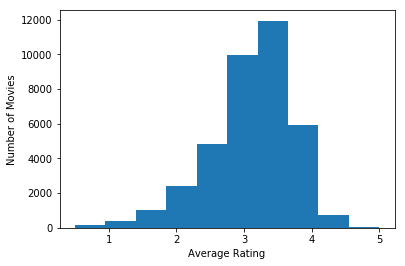

In [52]:
plt.hist(avg_ratings_1['rating'], bins = 10)
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')

As we can see, the vast majority of movies have an average rating of between 2.5 and 4 out of 5. The histogram has a pronounced negative skew, and very few movies appear to have an average rating above 4.

Let's also take a look at the distribution of number of ratings per movie and number of ratings per user.

In [53]:
n_ratings_per_movie = movieId_ratings.groupby('movieId').count()

Text(0.5,1,'Number of ratings per movie')

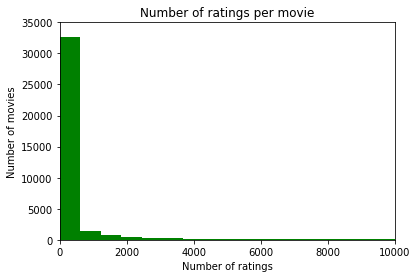

In [54]:
plt.hist(n_ratings_per_movie['rating'], bins = 150, color = 'g')
plt.xlabel('Number of ratings')
plt.ylabel('Number of movies')
plt.axis([0,10000,0,35000])
plt.title('Number of ratings per movie')

Note: Because we're excluding movies with only 1 review from the analysis, those movies are not displayed on this graph. If they were, the left-most bar would be 7659 movies higher.

From this graph, we can see that almost all movies have a relatively small number of reviews, and there is a profound positive skew. This is expected because there is a huge number of films that come out and don't become popular, and as a result have few reviews. Movies that do become very popular, however, do garner a significant number of reviews. 

The movie with the most reviews is Forrest Gump, with a whopping 91,921 ratings and a 4.05 star average rating.

In [55]:
n_ratings_per_user = movieId_ratings.groupby('userId').count()

Text(0.5,1,'Number of ratings per user')

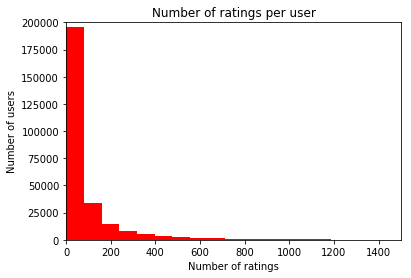

In [56]:
plt.hist(n_ratings_per_user['rating'], bins = 220, color = 'r')
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.axis([0,1500,0,200000])
plt.title('Number of ratings per user')

Note that there are outliers above where the x-axis of this histogram stops. In fact, one user rated over 17,000 different movies!

Let's zoom in on only the distribution of users who rated fewer than 250 movies:

Text(0.5,1,'Number of ratings per user')

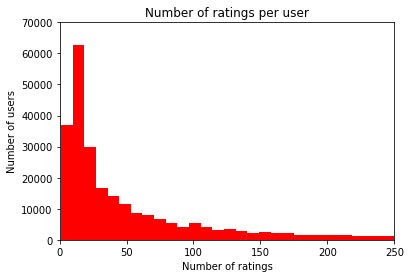

In [57]:
plt.hist(n_ratings_per_user['rating'], bins = 2000, color = 'r')
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.axis([0,250,0,70000])
plt.title('Number of ratings per user')

The number of ratings per user is important to us because we'll be basing our analysis off of how many movies a user has reviewed. Let's look at this data in a boxplot.

Text(0.5,1,'Number of ratings per user')

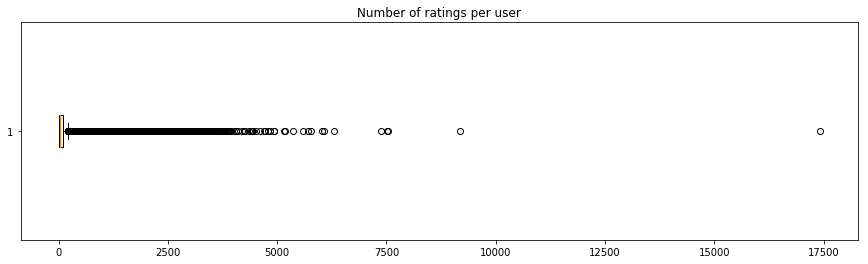

In [58]:
plt.rcParams['figure.figsize'] = [15,4]
plt.boxplot(n_ratings_per_user['rating'], vert=False)
plt.title('Number of ratings per user')

From the boxplot, we can see just how skewed this data set is. It's hard to see, but the actual box in the boxplot is clustered at the far left of the plot. 

It's still somewhat hard to get a feel for this dataset, so let's break it down into percentiles.

In [59]:
print('Mean = ' + str(n_ratings_per_user['rating'].mean()))
print('25th percentile = ' + str(np.percentile(n_ratings_per_user['rating'],25)))
print('Median = ' + str(n_ratings_per_user['rating'].median()))
print('75th percentile = ' + str(np.percentile(n_ratings_per_user['rating'],75)))
print('90th percentile = ' + str(np.percentile(n_ratings_per_user['rating'],90)))
print('99th percentile = ' + str(np.percentile(n_ratings_per_user['rating'],99)))

Mean = 96.03989014153137
25th percentile = 15.0
Median = 30.0
75th percentile = 93.0
90th percentile = 236.0
99th percentile = 963.0


Now that we have a better idea of how many movies each user has rated, let's start the statistical analysis on the data.

## Data Analysis

#### Setting up dataframes:

There are several different methods that can be used to analyze our data. For simplicity, let's split our movie reviewers into four groups based on their percentile ranking of number of movies rated. Then we will compare the z scores in each group to come to a conclusion on whether each group rates movies differently.

As we saw, the distribution of number of movies rated per user is extremely skewed, so we should take that into account when choosing groups. Let's try the ranges 0th-50th percentile, 50th-90th percentile, 90th-99th percentile, and 99th-100th percentile.

In [72]:
avg_zscore_per_user = pd.concat([n_ratings_per_user[['rating']], movieId_ratings[['userId','zscore']].groupby('userId').mean()], axis = 1, join = 'inner')

In [73]:
avg_zscore_per_user.columns = ['#_ratings','avg_zscore']
avg_zscore_per_user = avg_zscore_per_user.sort_values(by = ['#_ratings'])
avg_zscore_per_user.head()

,#_ratings,avg_zscore
userId,,
52669,1,1.198735
163690,1,1.279841
52492,1,0.386042
19726,1,0.397352
52487,1,1.224515


Now that we have a dataframe of each user's number of ratings and average z score, sorted by number of ratings, we can split it into 4 groups based on the number of ratings.

From above, the median number of reviews is 30, so let's put all users with 30 or fewer ratings into the dataframe group_0 (0-50th percentile). We use the same method for the other 3 groups, where group_1 is users who reviewed between 31 and 236 movies (50-90th percentile), group_2 is users who reviewed between 237 and 963 movies (90-99th percentile), and group_3 is users who reviewed 937 movies or more (99+ percentile).

Note that for this project, percentile is being used in the sense that a user at the 25th percentile has given more ratings than 25% of all users, and a user at the 99th percentile has given more ratings than 99% of all users (equivalently, we could say this user is in the top 1% based on number of ratings).

In [62]:
group_0 = avg_zscore_per_user[avg_zscore_per_user['#_ratings'] <= 30]
group_1 = avg_zscore_per_user[(avg_zscore_per_user['#_ratings'] >= 31) & (avg_zscore_per_user['#_ratings'] <= 236)]
group_2 = avg_zscore_per_user[(avg_zscore_per_user['#_ratings'] >= 237) & (avg_zscore_per_user['#_ratings'] <= 963)]
group_3 = avg_zscore_per_user[avg_zscore_per_user['#_ratings'] >= 937]

In [74]:
#Let's take a peek at group_1 just to check that the boundaries are correct:
print(group_1.head(3))
print(group_1.tail(3))

        #_ratings  avg_zscore
userId                       
51030          31    0.320753
208543         31   -0.792386
259222         31    0.481028
        #_ratings  avg_zscore
userId                       
165757        236   -0.606639
23685         236   -0.103590
269397        236    0.591736


#### Analysis:

For a start, let's just see what the average "average zscore" is for each group. Note that avg_avg_zscore means each group's average of all of the average zscores in that group.

In [67]:
data = [group_0['avg_zscore'].mean(), group_1['avg_zscore'].mean(), group_2['avg_zscore'].mean(), group_3['avg_zscore'].mean()]

In [68]:
data = [group_0['avg_zscore'].mean(), group_1['avg_zscore'].mean(), group_2['avg_zscore'].mean(), group_3['avg_zscore'].mean()]
avg_avg_zscore = pd.DataFrame(data, index = ['0-50th','50-90th','90-99th','99+'])
avg_avg_zscore.columns = ['avg_avg_zscore']d

In [69]:
avg_avg_zscore

,avg_avg_zscore
0-50th,0.039947
50-90th,0.103755
90-99th,-0.012575
99+,-0.143591


To get a more granular view of this data, let's thins time split the data into percentiles of 10 based on number of reviews and compare those average z-scores. This will allow us to visualize the bottom 10% next to the 10-20th % and so on.

In [70]:
print('10th percentile = ' + str(np.percentile(n_ratings_per_user['rating'],10)))
print('20th percentile = ' + str(np.percentile(n_ratings_per_user['rating'],20)))
print('30th percentile = ' + str(np.percentile(n_ratings_per_user['rating'],30)))
print('40th percentile = ' + str(np.percentile(n_ratings_per_user['rating'],40)))
print('50th percentile = ' + str(np.percentile(n_ratings_per_user['rating'],50)))
print('60th percentile = ' + str(np.percentile(n_ratings_per_user['rating'],60)))
print('70th percentile = ' + str(np.percentile(n_ratings_per_user['rating'],70)))
print('80th percentile = ' + str(np.percentile(n_ratings_per_user['rating'],80)))
print('90th percentile = ' + str(np.percentile(n_ratings_per_user['rating'],90)))

10th percentile = 6.0
20th percentile = 13.0
30th percentile = 16.0
40th percentile = 20.0
50th percentile = 30.0
60th percentile = 46.0
70th percentile = 72.0
80th percentile = 119.0
90th percentile = 236.0


In [71]:
group_0_10 = avg_zscore_per_user[avg_zscore_per_user['#_ratings'] <= 6]
group_10_20 = avg_zscore_per_user[(avg_zscore_per_user['#_ratings'] >= 7) & (avg_zscore_per_user['#_ratings'] <= 13)]
group_20_30 = avg_zscore_per_user[(avg_zscore_per_user['#_ratings'] >= 14) & (avg_zscore_per_user['#_ratings'] <= 16)]
group_30_40 = avg_zscore_per_user[(avg_zscore_per_user['#_ratings'] >= 17) & (avg_zscore_per_user['#_ratings'] <= 20)]
group_40_50 = avg_zscore_per_user[(avg_zscore_per_user['#_ratings'] >= 21) & (avg_zscore_per_user['#_ratings'] <= 30)]
group_50_60 = avg_zscore_per_user[(avg_zscore_per_user['#_ratings'] >= 31) & (avg_zscore_per_user['#_ratings'] <= 46)]
group_60_70 = avg_zscore_per_user[(avg_zscore_per_user['#_ratings'] >= 47) & (avg_zscore_per_user['#_ratings'] <= 72)]
group_70_80 = avg_zscore_per_user[(avg_zscore_per_user['#_ratings'] >= 73) & (avg_zscore_per_user['#_ratings'] <= 119)]
group_80_90 = avg_zscore_per_user[(avg_zscore_per_user['#_ratings'] >= 120) & (avg_zscore_per_user['#_ratings'] <= 236)]
group_90_100 = avg_zscore_per_user[(avg_zscore_per_user['#_ratings'] >= 237)]

In [76]:
data_1 = [group_0_10['avg_zscore'].mean(), group_10_20['avg_zscore'].mean(), 
        group_20_30['avg_zscore'].mean(), group_30_40['avg_zscore'].mean(),
        group_40_50['avg_zscore'].mean(), group_50_60['avg_zscore'].mean(),
        group_60_70['avg_zscore'].mean(), group_70_80['avg_zscore'].mean(),
        group_80_90['avg_zscore'].mean(), group_90_100['avg_zscore'].mean(),]
avg_avg_zscore_1 = pd.DataFrame(data_1, index = ['0-10th','10-20th','20-30th','30-40th','40-50th','50-60th',
                                                 '60-70th','70-80th','80-90th','90-100th'])
avg_avg_zscore_1.columns = ['avg_avg_zscore']

In [78]:
avg_avg_zscore_1.head(10)

,avg_avg_zscore
0-10th,0.077350
10-20th,0.061931
20-30th,-0.011007
30-40th,-0.029808
40-50th,0.096660
50-60th,0.123888
60-70th,0.121028
70-80th,0.102809
80-90th,0.068049
90-100th,-0.025674


In [103]:
data_2 = []
percentile_index = []
for i in range(1,101):
    ratings_low = np.percentile(n_ratings_per_user['rating'],i)
    if i != 100:
        ratings_high = np.percentile(n_ratings_per_user['rating'],i+1)
    if i == 1:
        group = avg_zscore_per_user[avg_zscore_per_user['#_ratings'] <= ratings_low]
    elif i == 100:
        group = avg_zscore_per_user[avg_zscore_per_user['#_ratings'] > np.percentile(n_ratings_per_user['rating'],i-1)]
    else:
        group = avg_zscore_per_user[(avg_zscore_per_user['#_ratings'] >= ratings_low) & 
                                    (avg_zscore_per_user['#_ratings'] <= ratings_high)]
    data_2.append(group['avg_zscore'].mean())
    percentile_index.append(i)
avg_avg_zscore_2 = pd.DataFrame({'Percentile': percentile_index, 'Z-score': data_2})

Text(0.5,1,'Average rating deviation, by percentile of number of ratings')

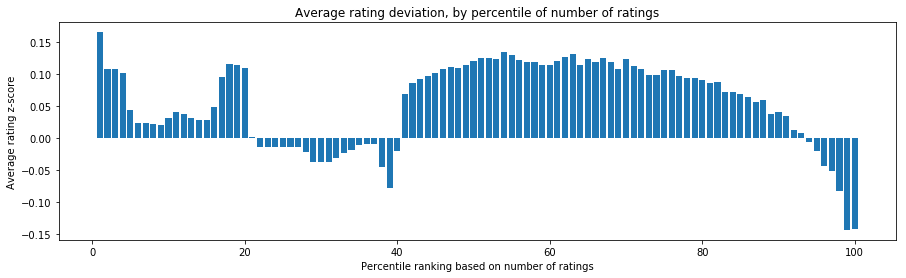

In [114]:
bar = plt.bar(avg_avg_zscore_2['Percentile'], avg_avg_zscore_2['Z-score'])
plt.xlabel('Percentile ranking based on number of ratings')
plt.ylabel('Average rating z-score')
plt.title('Average rating deviation, by percentile of number of ratings')

## Conclusion

As we can see, there clearly is a difference in how each people rate movies based on how many ratings they gave. Users at the very bottom percentiles, who rated less than about 5 movies, tended to be more generous in their ratings and rated about 0.1 stars higher than the average. The 20th through 40th percentiles were on average slightly more critical than other users. The 40th through 94th percentiles also were much more generous than other users, although this effect diminished gradually with higher percentiles. Above the 95th percentile, users were increasingly critical compared to the average, and the top 2 percentiles gave ratings almost 0.15 stars below the average, which is by far the most critical of all the groups. 

Intuitively, these trends makes sense. People who only rate a couple movies probably don't watch a ton of movies, so they are more likely to enjoy the movies and less likely to spot flaws and common tropes that more experienced users might spot. Similarly, the people in the top 5% of number of movies rated are huge movie buffs and would be more likely to recognize overused cliches. 

Also, because we're using such a large dataset, each percentile has over 2800 users. This means that these differences will be statistically significant (and we could do further analysis with statsmodels to prove this). However, these differences are still relatively small (~0.15 stars) compared to the total rating system (out of 5 stars).

Another limitations of this data is the fact that the users of this relatively obscure site (movielens.org) are biased as being more likely to be movie enthusiasts.

Still, if you're a movie studio and you need to choose who to allow in for your early media screenings, you might want to think twice about the reviewer who's done nothing but rate tens of thousands of movies over this lifetime.

Thanks for reading!